In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

from policy import ResNet, ConvNet

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import JointEmbeddingModel, get_data, convert_integers_to_explinations

lr = 0.001
epochs = 10
batch_size = 128
num_epochs = 10
input_state_embed = 64
hidden_state_embed = 32
output_state_embed = 16 
exp_embed = 32
output_exp_embed = 16

model_name = "net"
session_name = "falcon"
board_size = 5
board_name = f'{board_size}x{board_size}'
resnet = False

model_type = "resnet" if resnet else "convnet"

agents_to_sample = [0, 10, 20, 60, 100, 500, 1000]
cases_to_sample = 100

full_model_path = f"../models/saved_sessions/{model_type}/board_size_{board_size}/{session_name}/"

def load_model(full_name, model_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    if resnet:
        model = ResNet(board_size, model_path)
    else:
        model = ConvNet(board_size, model_path)
    return model

agents = [load_model(full_model_path, model_name, epoch) for epoch in agents_to_sample]

# Load the data
states, explinations, labels, max_sent_len, vocab = get_data(agents, cases_to_sample, board_size)

vocab_size = len(vocab)

print(states.shape, explinations.shape, labels.shape, max_sent_len, vocab_size)



Positive cases: 123it [00:29,  4.14it/s]                         
Positive cases: 101it [01:26,  1.17it/s]                         
Positive cases: 147it [00:07, 19.94it/s]                        
Positive cases: 749it [00:15, 47.06it/s]                        

(800, 5, 5, 5) (800, 8) (800,) 8 18


### Train the joint embedding model

In [3]:
jem = JointEmbeddingModel(vocab_size=vocab_size, max_sent_len=max_sent_len, board_size=board_size, learning_rate=lr)

jem.fit(states, explinations, labels, batch_size=batch_size, epochs=50)

jem.save_model('../models/jem/joint_embedding_model.keras')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 5, 32)     1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 5, 32)     9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 5, 32)     9248        ['conv2d_1[0][0]']               
                                                                                              

2024-02-17 18:14:41.635548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


7/7 [==============================] - 8s 133ms/step - loss: 34.5424 - combined_output_loss: 34.5424
Epoch 2/50
7/7 [==============================] - 1s 81ms/step - loss: 31.9655 - combined_output_loss: 31.9655
Epoch 3/50
7/7 [==============================] - 0s 70ms/step - loss: 31.5309 - combined_output_loss: 31.5309
Epoch 4/50
7/7 [==============================] - 1s 72ms/step - loss: 31.2840 - combined_output_loss: 31.2840
Epoch 5/50
7/7 [==============================] - 1s 73ms/step - loss: 31.2766 - combined_output_loss: 31.2766
Epoch 6/50
7/7 [==============================] - 1s 73ms/step - loss: 31.2986 - combined_output_loss: 31.2986
Epoch 7/50
7/7 [==============================] - 0s 70ms/step - loss: 31.2063 - combined_output_loss: 31.2063
Epoch 8/50
7/7 [==============================] - 0s 66ms/step - loss: 31.1188 - combined_output_loss: 31.1188
Epoch 9/50
7/7 [==============================] - 0s 69ms/step - loss: 31.1504 - combined_output_loss: 31.1504
Epoch 10/50

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.009255
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.377106
[t-SNE] KL divergence after 1000 iterations: -0.334706


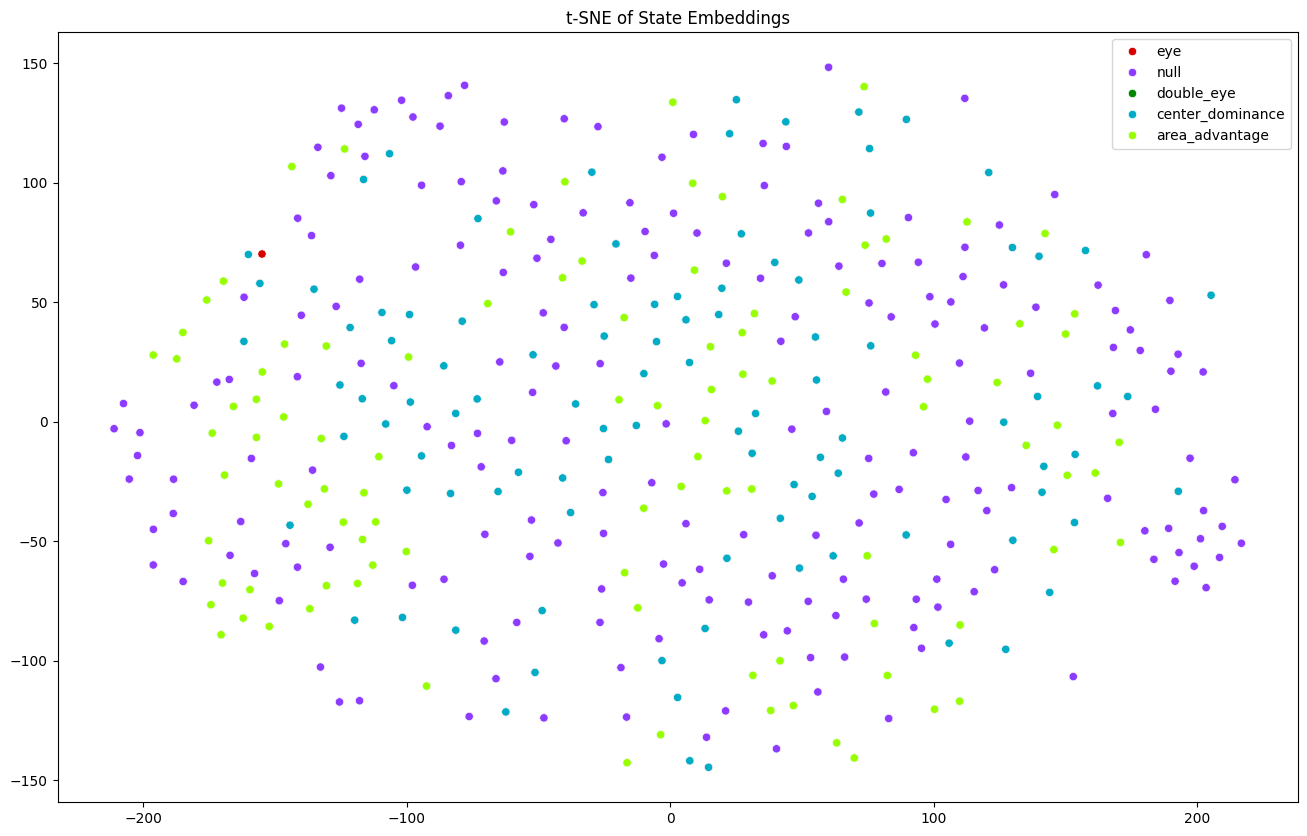

In [4]:
# Import necessary modules
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc

# Define necessary variables
state_embeddings = []
explination_predictions = []

# Get the embeddings
for i in range(len(states)):
    state_embed, exp_embed, _ = jem.predict(states[i], explinations[i])
    state_embeddings.append(state_embed)
    # Get the explination converted to a string
    explination = convert_integers_to_explinations(explinations[i], vocab)
    explination_predictions.append(explination)

new_state_embed = []

for list_ in state_embeddings:
    new_state_embed.append(list_[0])
    
new_state_embed = np.array(new_state_embed)
explination_predictions = np.array(explination_predictions)

# Fit the t-sne
tsne = TSNE(n_components=2, verbose=1)
state_embed_tsne = tsne.fit_transform(new_state_embed)

# Plot the t-sne
palette = sns.color_palette(cc.glasbey, 5)
plt.figure(figsize=(16,10))
sns.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explination_predictions, legend='full', palette=palette)
plt.title('t-SNE of State Embeddings')
plt.plot()
plt.show()